In [1]:
import pandas as pd
from database.market import Market
from datetime import datetime,timedelta
from parameters.parameters import Parameters
from backtester.backtester_lite import BacktesterLite
from processor.processor import Processor as p
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
market = Market()

In [3]:
market.connect()
sp500 = market.retrieve("sp500").rename(columns={"Symbol":"ticker"})
market.disconnect()

In [4]:
start_date = datetime(2001,1,1)
end_date = datetime(2020,1,1)
lookbacks = [5,20,60]
ceilings = [0.1,0.5,1,10]
floors = [-10,0,0.05,0.1]
holding_periods = [1]
positions = 20

In [5]:
parameters = Parameters.parameters_lite(lookbacks,holding_periods,ceilings,floors)

In [6]:
len(parameters)

192

In [7]:
simulation = []
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        ticker_data = market.retrieve_ticker_prices("stocks",ticker)
        ticker_data = p.column_date_processing(ticker_data)
        ticker_data.sort_values("date",inplace=True)
        ticker_data = ticker_data[["date","ticker","adjclose"]]
        ticker_data["prev_close"] = ticker_data["adjclose"].shift(1)
        for lookback in lookbacks:
            ticker_data[f"window_{lookback}"] = ticker_data["prev_close"].shift(lookback)
            ticker_data[f"rolling_{lookback}"] = ticker_data["prev_close"].rolling(lookback).mean()
        for holding_period in holding_periods:
            ticker_data[f"return_{holding_period}"] = (ticker_data["adjclose"].shift(-holding_period) - ticker_data["adjclose"]) / ticker_data["adjclose"]
        simulation.append(ticker_data.dropna())
    except Exception as e:
        print(ticker,str(e))
market.disconnect()
final = pd.concat(simulation)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:36<00:00, 13.56it/s]


In [8]:
final

,date,ticker,adjclose,prev_close,window_5,rolling_5,window_20,rolling_20,window_60,rolling_60,return_1
61,2000-03-30,MMM,24.209033,23.836377,23.392998,24.101317,23.428360,23.278617,25.512158,24.437092,-0.004944
62,2000-03-31,MMM,24.089348,24.209033,23.665010,24.210121,23.409319,23.318603,24.498484,24.432268,0.037489
63,2000-04-03,MMM,24.992427,24.089348,24.720415,24.083908,24.345039,23.305819,25.747331,24.404635,0.011537
64,2000-04-04,MMM,25.280759,24.992427,24.108389,24.260715,23.733013,23.368789,27.247569,24.367049,-0.019475
65,2000-04-05,MMM,24.788418,25.280759,24.176392,24.481589,22.508961,23.507379,27.788195,24.325258,0.024690
...,...,...,...,...,...,...,...,...,...,...,...
2641,2023-08-01,ZTS,185.510000,188.090000,185.580000,189.766000,172.210000,176.604218,177.730000,173.947906,-0.018921
2642,2023-08-02,ZTS,182.000000,185.510000,190.150000,188.838000,170.230000,177.368218,178.470000,174.065239,-0.006154
2643,2023-08-03,ZTS,180.880000,182.000000,192.000000,186.838000,169.350000,178.000718,186.230000,173.994739,-0.012439
2644,2023-08-04,ZTS,178.630000,180.880000,188.690000,185.276000,168.470000,178.621218,184.870000,173.928239,0.011532


In [9]:
all_trades = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        trades = BacktesterLite.backtest(positions,final.copy(),iteration,parameter,False)
        all_trades.append(trades)
    except Exception as e:
        print(str(e))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [04:42<00:00,  1.47s/it]


In [27]:
analysis = pd.concat(all_trades)
analysis["return"] = analysis["return"] + 1

In [29]:
report = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        iteration_trades = analysis[analysis["iteration"]==iteration]
        iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
        cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
        for i in range(positions):
            if float(i) not in cumulative.columns:
                cumulative[float(i)] = 1
        cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
        iter_report = cumulative.cumprod().iloc[-1]
        for key in parameter.keys():
            iter_report[key] = parameter[key]
        iter_report["iteration"] = iteration
        report.append(iter_report[["pv","iteration"] + list(parameter.keys())])
    except Exception as e:
        print(str(e))
        continue

 10%|████████████████▎                                                                                                                                                    | 19/192 [00:08<01:13,  2.37it/s]

single positional indexer is out-of-bounds


 18%|██████████████████████████████                                                                                                                                       | 35/192 [00:15<01:12,  2.17it/s]

single positional indexer is out-of-bounds


 35%|█████████████████████████████████████████████████████████▌                                                                                                           | 67/192 [00:28<00:52,  2.40it/s]

single positional indexer is out-of-bounds


 43%|███████████████████████████████████████████████████████████████████████▎                                                                                             | 83/192 [00:35<00:49,  2.18it/s]

single positional indexer is out-of-bounds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [01:22<00:00,  2.32it/s]


In [30]:
performance = pd.DataFrame(report)

In [31]:
performance.sort_values("pv",ascending=False).head(20)

position,pv,iteration,strategy,value,lookback,holding_period,ceiling,floor
4778,487.126853,108,window,True,5,1,10.0,-10.0
4778,439.473574,45,rolling,True,60,1,10.0,0.0
4778,439.473574,44,rolling,True,60,1,10.0,-10.0
4778,413.164141,109,window,True,5,1,10.0,0.0
4778,400.283394,104,window,True,5,1,1.0,-10.0
4778,385.461677,29,rolling,True,20,1,10.0,0.0
4778,368.015395,28,rolling,True,20,1,10.0,-10.0
4778,343.104095,12,rolling,True,5,1,10.0,-10.0
4778,339.506524,105,window,True,5,1,1.0,0.0
4778,326.261334,8,rolling,True,5,1,1.0,-10.0


In [32]:
iteration = performance.sort_values("pv",ascending=False).iloc[0]["iteration"]
parameter = parameters[iteration]
iteration_trades = analysis[analysis["iteration"]==iteration]
iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
cumulative["pv"] = cumulative["pv"].cumprod()

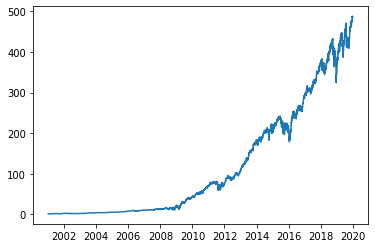

In [33]:
plt.plot(cumulative["date"],cumulative["pv"])

In [34]:
parameter

{'strategy': 'window',
 'value': True,
 'lookback': 5,
 'holding_period': 1,
 'ceiling': 10,
 'floor': -10}